In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import csv
import time
import matplotlib.pyplot as plt

class Mydataset(Dataset):
    
    def __init__(self, x, y=None):
        self.x = torch.FloatTensor(x)
        self.y = y
        if y is not None:
            self.y = torch.FloatTensor(y)
    
    def __getitem__(self, index):
        if self.y is None:
            return self.x[index]
        else:
            return self.x[index], self.y[index]
  
    def __len__(self):
        return len(self.x)

class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(),
            nn.LeakyReLU(),
            nn.Linear(32, 1),
        )
  
    def forward(self, x):
        return self.net(x).squeeze(1)

def test(x, model):
    test_set = Mydataset(x)
    test_loader = DataLoader(test_set, shuffle=False)
    model.eval()
    ans = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            test_pred = model(data.cuda())
            for pred in test_pred:
                ans.append(float(pred.cpu().data.numpy()))
    return ans

In [3]:
dfg = pd.read_csv("LBMA-GOLD.csv")
dfb = pd.read_csv("BCHAIN-MKPRU.csv")

df = dfb
df["Gold"] = np.nan
tot = len(dfb)
p = len(dfg) - 1
pre = -1
for i in range(tot - 1, -1, -1):
    sl = dfb.iloc[i, 0]
    if (sl[0] == "2" and sl[1] == "0"):
        sl = sl[2:]
    if (sl[0] == "0"):
        sl = sl[1:]
        
    if (sl == dfg.iloc[p, 0]):
        df.iloc[i, 2] = dfg.iloc[p, 1]
        p -= 1
        
    if (np.isnan(df.iloc[i, 2])):
        df.iloc[i, 2] = df.iloc[i + 1, 2]     
    df.iloc[i, 0] = sl

#0是比特币 1是黄金
x = df.iloc[:, 1:3].values
model_b = torch.load("Bitcoin_model.pkl")
model_g = torch.load("Gold_model.pkl")
x

array([[  621.65,  1324.6 ],
       [  609.67,  1324.6 ],
       [  610.92,  1323.65],
       ...,
       [46809.17,  1786.  ],
       [46078.38,  1788.25],
       [46368.69,  1794.6 ]])

In [4]:
windows = 5
n = len(x)
data_b = np.zeros((n - windows, windows), dtype=float)
data_g = np.zeros((n - windows, windows), dtype=float)
for i in range(n - windows):
    data_b[i, :] = x[i: i + windows, 0]
    data_g[i, :] = x[i: i + windows, 1]
    
x0 = data_b
x1 = data_g
x0 = (x0 - x0.min()) / (x0.max() - x0.min())
x1 = (x1 - x1.min()) / (x1.max() - x1.min())

y0 = test(x0, model_b)
y1 = test(x1, model_g)


In [5]:
y0 = np.array(y0).reshape(-1, 1)
y1 = np.array(y1).reshape(-1, 1)
y = np.concatenate([y0, y1], axis = 1)
y

array([[  915.7064209 ,  1278.85205078],
       [  915.67602539,  1273.94372559],
       [  913.60168457,  1294.41040039],
       ...,
       [47889.4375    ,  1717.72155762],
       [42852.66015625,  1683.76782227],
       [41952.6171875 ,  1720.8104248 ]])

In [17]:
dfg = pd.read_csv("LBMA-GOLD.csv")
dfb = pd.read_csv("BCHAIN-MKPRU.csv")

df = dfb
df["Gold"] = np.nan
tot = len(dfb)
p = len(dfg) - 1
pre = -1
shinan = np.zeros(2000)
for i in range(tot - 1, -1, -1):
    sl = dfb.iloc[i, 0]
    if (sl[0] == "2" and sl[1] == "0"):
        sl = sl[2:]
    if (sl[0] == "0"):
        sl = sl[1:]
        
    if (sl == dfg.iloc[p, 0]):
        df.iloc[i, 2] = dfg.iloc[p, 1]
        p -= 1
        
    if (np.isnan(df.iloc[i, 2])):
        shinan[i] = 1
        df.iloc[i, 2] = df.iloc[i + 1, 2]     
    df.iloc[i, 0] = sl

In [30]:


#0是比特币 1是黄金
x = df.iloc[:, 1:3].values

jg = x
bl = np.zeros((tot, 2))
lr = np.zeros((tot, 2))
cq = np.zeros((tot, 2))
dq = np.zeros((tot, 2))
for i in range(1, tot):
    bl[i, 0] = x[i, 0] / x[i - 1 , 0]
    bl[i, 1] = x[i, 1] / x[i - 1, 1] 
bl[0, 0] = 1
bl[0, 1] = 1
x = bl
win_short = 12
win_long = 5
alfb = 0.02
alfg = 0.01

bb = 0.007
bg = 0.0043


money = 1000
bit = 0
gold = 0
money_lis = []
bit_lis = []
gold_lis = []

ans = []
for i in range(len(y0)):
    c = i + 5
    dq[i] = np.mean(x[max(0, c - win_short): c, :], axis = 0)
    cq[i] = np.mean(x[max(0, c - win_long): c, :], axis = 0)
    
    lr[i] = cq[i] / dq[i]
    rate = cq[i] / dq[i]
    if money > 0:
        if (rate[0] > 1 + bb and rate[1] > 1 + bg):
            if rate[0] > rate[1] and money * alfb < y[i, 0] * (1 + bb) - money:
                bit += money * (1 - alfb) / jg[i, 0]
                money = 0
            elif money * alfb < y[i, 1] * (1 + bg) - money and shinan[i] == 0:
                gold += money * (1 - alfg) / jg[i, 1]
                money = 0
        elif rate[0] > 1 + bb:
            bit += money * (1 - alfb) / jg[i, 0]
            money = 0
        elif rate[1] > 1 + bg and shinan[i] == 0:
            gold += money * (1 - alfg) / jg[i, 1]
            money = 0
        
        if money == 0:
            ans.append([i, round(money, 2), round(bit, 2), round(gold, 2), round(jg[i, 0], 2), jg[i, 1], "Buy"])
        
    
    if (rate[0] < 0.99 and bit > 0):
        money += bit * jg[i, 0] * (1-alfb)
        bit = 0
        ans.append([i, round(money, 2), round(bit, 2), round(gold, 2), round(jg[i, 0], 2), jg[i, 1], "Sell"])
        
    if (rate[1] < 0.997 and shinan[i] == 0 and gold > 0):
        money += gold * jg[i, 1] * (1-alfg)
        gold = 0
        ans.append([i,round(money, 2), round(bit, 2), round(gold, 2), round(jg[i, 0], 2), jg[i, 1], "Sell"])
    
    
    money_lis.append(money)
    bit_lis.append(bit)
    gold_lis.append(gold)

print(money + bit * jg[-1,0] * (1-alfb) + gold * jg[-1,1] * (1-alfg))

ans = np.array(ans)

da = pd.DataFrame(ans)

da.columns=["Day", "Money", "Bitcoin", "Gold", "Bitcoin Value", "Gold USD", "Operation"]
da.to_excel(excel_writer='Trading_strategy.xlsx', sheet_name='sheet_1')
da

1544608.993385148


,Day,Money,Bitcoin,Gold,Bitcoin Value,Gold USD,Operation
0,64,0,1.39,0,706.46,1213.6,Buy
1,114,1377.7,0,0,1013.42,1151.0,Sell
2,123,0,1.73,0,780.92,1205.05,Buy
3,130,1517.78,0,0,895.8,1196.05,Sell
4,141,0,1.63,0,912.19,1192.8,Buy
...,...,...,...,...,...,...,...
168,1771,0,34.08,0,31520.66,1814.9,Buy
169,1782,1336084.88,0,0,40002.53,1829.3,Sell
170,1788,0,34.33,0,38138.0,1829.1,Buy
171,1795,1534521.01,0,0,45608.37,1743.6,Sell


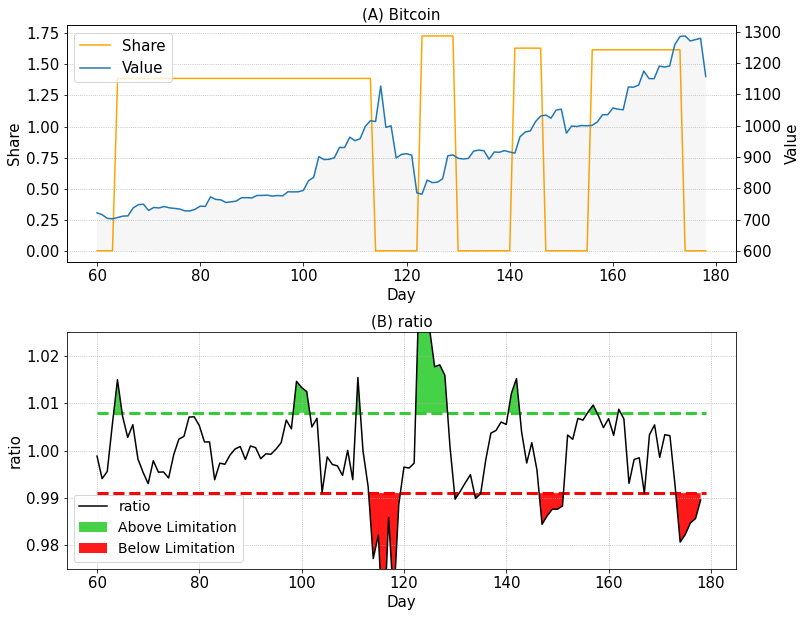

'\nday  64 :  0 1.3871981428530984 0 danjia: 706.46 1213.6\nday  114 :  1377.698055091583 0 0 danjia: 1013.42 1151.0\nday  123 :  0 1.7289147338904771 0 danjia: 780.92 1205.05\nday  130 :  1517.7846761182134 0 0 danjia: 895.798875 1196.05\nday  141 :  0 1.630613120726876 0 danjia: 912.19 1192.8\nday  147 :  1652.4447475550396 0 0 danjia: 1034.07 1226.75\nday  156 :  0 1.6174549067158797 0 danjia: 1001.2 1230.75\nday  174 :  2040.03117564447 0 0 danjia: 1287.0 1230.95\nday  179 :  0 1.67654698980465 0 danjia: 1192.469143 1206.55\nday  183 :  2017.0979442745052 0 0 danjia: 1227.68 1204.2\n'

In [11]:
fig = plt.figure(figsize=(12, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
ax1 = plt.subplot(211)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax3 = plt.subplot(212)
plt.xticks(fontsize=15)

st = 60
ed = 179
p1 = ax1.plot(list(range(st, ed)), bit_lis[st:ed], color = "orange", label="Share")
ax1.legend(fontsize=15)
ax1.grid(b=True, axis='y', ls=':')

plt.yticks(fontsize=15)
ax2 = ax1.twinx()
plt.yticks(fontsize=15)
p2 = ax2.plot(list(range(st, ed)), jg[st:ed, 0], label="Value")

lns = p1 + p2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=15, loc = 2)

ax2.fill_between(list(range(st, ed)),jg[st:ed, 0],600,facecolor = 'gray', alpha = 0.07)

lr[64, 0] = 1.015
ax3.plot(list(range(st, ed)), lr[st:ed, 0], color="black", label = "ratio")
ax3.hlines(y=1.008, xmin=st, xmax=ed, linestyles='dashed', color="limegreen", linewidth=3)
ax3.hlines(y=0.991, xmin=st, xmax=ed, linestyles='dashed', color="red", linewidth=3)

ax3.fill_between(list(range(st, ed)),lr[st:ed, 0] ,1.008,facecolor = 'limegreen'
                 , alpha = 0.9, where=(lr[st:ed, 0]>1.008), interpolate=True
                 , label='Above Limitation')

ax3.fill_between(list(range(st, ed)),0.991, lr[st:ed, 0], facecolor = 'red', 
                 alpha = 0.9, where=(lr[st:ed, 0]<0.991), interpolate=True
                 , label='Below Limitation')
ax1.set_title("(A) Bitcoin", fontsize=15)
ax1.set_ylabel('Share', fontsize=15)
ax2.set_ylabel('Value', fontsize=15)
ax1.set_xlabel('Day', fontsize=15)

ax3.grid(b=True, ls=':')
ax3.set_title("(B) ratio", fontsize=15)
ax3.set_ylabel('ratio', fontsize=15)
ax3.set_xlabel('Day', fontsize=15)

ax3.set_ylim(0.975, 1.025)
ax3.legend(fontsize=14)

plt.savefig("bit_rate.png")
plt.show()

"""
day  64 :  0 1.3871981428530984 0 danjia: 706.46 1213.6
day  114 :  1377.698055091583 0 0 danjia: 1013.42 1151.0
day  123 :  0 1.7289147338904771 0 danjia: 780.92 1205.05
day  130 :  1517.7846761182134 0 0 danjia: 895.798875 1196.05
day  141 :  0 1.630613120726876 0 danjia: 912.19 1192.8
day  147 :  1652.4447475550396 0 0 danjia: 1034.07 1226.75
day  156 :  0 1.6174549067158797 0 danjia: 1001.2 1230.75
day  174 :  2040.03117564447 0 0 danjia: 1287.0 1230.95
day  179 :  0 1.67654698980465 0 danjia: 1192.469143 1206.55
day  183 :  2017.0979442745052 0 0 danjia: 1227.68 1204.2
"""

In [ ]:
for i in range(750, 780):
    gold_lis[i]= bit_lis[i] * 6
    print(bit_lis[i], gold_lis[i])
    bit_lis[i] = 0

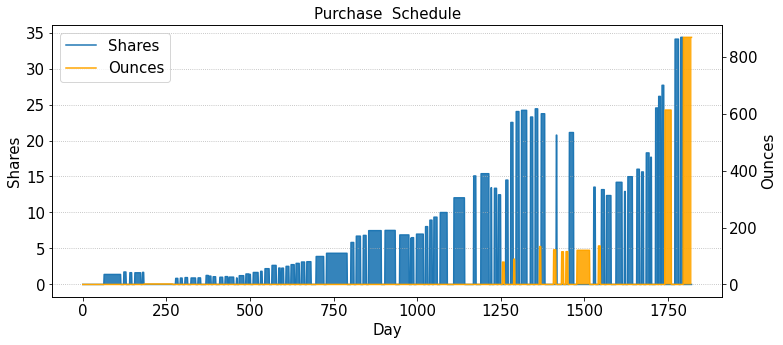

In [14]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)
    
p1 = ax1.plot(bit_lis, label="Shares")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax2 = ax1.twinx()
p2 = ax2.plot(gold_lis, label="Ounces", color="orange")

lns = p1 + p2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=15, loc = 2)

ax1.set_title("Purchase  Schedule", fontsize=15)
ax1.set_ylabel('Shares', fontsize=15)
ax2.set_ylabel('Ounces', fontsize=15)
ax1.set_xlabel('Day', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

xzb = list(range(len(bit_lis)))
ax1.fill_between(xzb, bit_lis ,0 #, facecolor = 'limegreen'
                 , alpha = 0.9, interpolate=True)
ax2.fill_between(xzb, gold_lis ,0 , facecolor = 'orange'
                 , alpha = 0.9, interpolate=True)
ax1.grid(b=True, axis="y", ls=':')
plt.savefig("PurchaseSchedule.png")
plt.show()

In [120]:
def work3(alfg, alfb):
    win_short = 12
    win_long = 5

    bb = 0.007
    bg = 0.0043

    money = 1000
    bit = 0
    gold = 0
    money_lis = []
    bit_lis = []
    gold_lis = []
    for i in range(len(y0)):
        c = i + 5
        dq[i] = np.mean(x[max(0, c - win_short): c, :], axis = 0)
        cq[i] = np.mean(x[max(0, c - win_long): c, :], axis = 0)
    
        lr[i] = cq[i] / dq[i]
        rate = cq[i] / dq[i]
        if money > 0:
            if (rate[0] > 1 + bb and rate[1] > 1 + bg):
                if rate[0] > rate[1] and money * alfb < y[i, 0] * (1 + bb) - money:
                    bit += money * (1 - alfb) / jg[i, 0]
                    money = 0
                elif money * alfb < y[i, 1] * (1 + bg) - money and shinan[i] == 0:
                    gold += money * (1 - alfg) / jg[i, 1]
                    money = 0
            elif rate[0] > 1 + bb:
                bit += money * (1 - alfb) / jg[i, 0]
                money = 0
            elif rate[1] > 1 + bg and shinan[i] == 0:
                gold += money * (1 - alfg) / jg[i, 1]
                money = 0
        
    
        if (rate[0] < 0.99 and bit > 0):
            money += bit * jg[i, 0] * (1-alfb)
            bit = 0
        
        if (rate[1] < 0.997 and shinan[i] == 0 and gold > 0):
            money += gold * jg[i, 1] * (1-alfg)
            gold = 0
    
    return money + bit * jg[-1,0] * (1-alfb) + gold * jg[-1,1] * (1-alfg)

n = 10
m = 9
ans = np.zeros((n, m))
ix = []
iy = []
for i in range(n):
    ix.append((i + 5) * 0.005)
for i in range(m):  
    iy.append((i+6) * 0.002)
    
for i in range(n):
    for j in range(m):
        ans[i,j] = round(work3( ix[i], iy[j]), 2)
df = pd.DataFrame(ans)

for i in range(n):
    ix[i] = round(ix[i] * 100, 1)
    ix[i] = str(ix[i])
    ix[i] = ix[i] + "%"
    
for i in range(m):   
    iy[i] = round(iy[i] * 100, 1)
    iy[i] = str(iy[i])
    iy[i] = iy[i] + "%"

df.index = ix
df.columns = iy
# df.to_excel(excel_writer='sensitive.xlsx', sheet_name='sheet_1')
df

,1.2%,1.4%,1.6%,1.8%,2.0%,2.2%,2.4%,2.6%,2.8%
2.5%,3798725.35,2791729.84,2050393.80,1504972.14,1103940.90,809260.32,592863.35,434054.00,317581.05
3.0%,3392458.19,2493159.12,1831107.70,1344017.95,985876.31,722711.32,529457.63,387632.67,283616.31
3.5%,3027870.13,2225218.89,1634318.24,1199576.12,879924.02,645041.41,472556.73,345973.72,253136.01
4.0%,2700868.73,1984901.55,1457816.50,1070025.29,784894.72,575378.76,421521.94,308609.54,225798.04
4.5%,2407745.20,1769481.47,1299600.62,953896.14,699710.60,512933.28,375774.44,275116.35,201292.33
5.0%,2145140.12,1576489.78,1157857.33,849857.74,623395.40,456989.28,334789.92,245110.28,179338.01
5.5%,1910012.18,1403691.37,1030945.06,756705.17,555065.28,406898.87,298093.73,218243.85,159680.85
6.0%,1699609.42,1249063.80,917378.41,673348.19,493920.51,362075.78,265256.38,194202.58,142090.75
6.5%,1511443.05,1110778.03,815814.04,598800.78,439237.81,321989.82,235889.44,172702.12,126359.67
7.0%,1343263.51,987180.83,725037.72,532171.71,390363.45,286161.74,209641.82,153485.41,112299.52


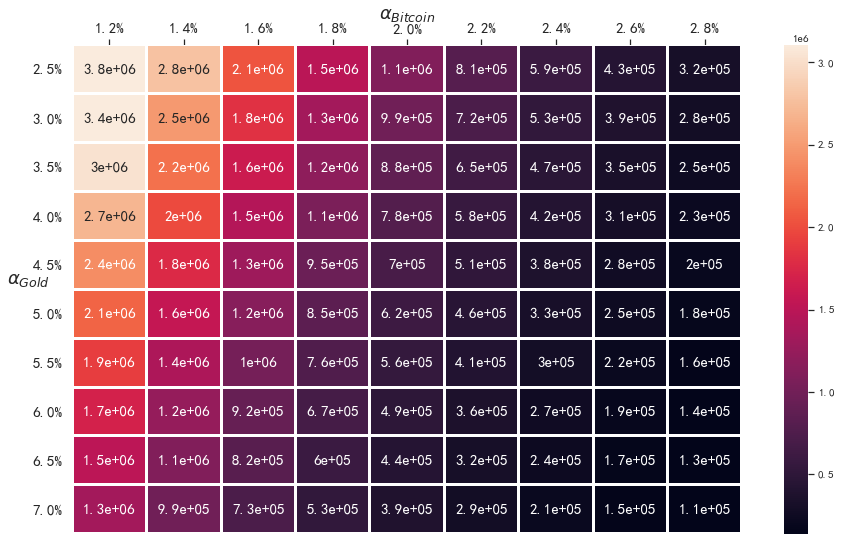

In [148]:
import seaborn as sns

sns.set()
plt.rcParams['font.sans-serif']='SimHei'#设置中文显示，必须放在sns.set之后
np.random.seed(0)


cmap = sns.cubehelix_palette(start = 1.5, rot = 2, gamma=0.9, as_cmap = True)


f, ax = plt.subplots(figsize=(15, 9))
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
#heatmap后第一个参数是显示值,vmin和vmax可设置右侧刻度条的范围,
#参数annot=True表示在对应模块中注释值
# 参数linewidths是控制网格间间隔
#参数cbar是否显示右侧颜色条，默认显示，设置为None时不显示
#参数cmap可调控热图颜色，具体颜色种类参考：https://blog.csdn.net/ztf312/article/details/102474190
sns.heatmap(ans, robust=True, annot=True,linewidths=2, 
            annot_kws={'size':15},
            yticklabels=df.index,  # 列标签
            xticklabels=df.columns)   # 行标签)


#设置坐标字体方向，通过rotation参数可以调节旋转角度
label_y = ax.get_yticklabels()
plt.setp(label_y, rotation=360, horizontalalignment='right')
label_x = ax.get_xticklabels()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel(r"$\alpha_{Bitcoin}$", fontsize = 18)

ax.set_ylabel(r"$\alpha_{Gold}$", fontdict={'size': 18}, rotation=0, x=-0.3, y=0.5)


plt.savefig("heatmap.png")
plt.show()

In [240]:
def work4(alfg=0.01, alfb=0.02, win_short = 12, win_long = 5, k = 0.99, k2=0.997):

    bb = 0.007
    bg = 0.0043

    money = 1000
    bit = 0
    gold = 0
    money_lis = []
    bit_lis = []
    gold_lis = []
    for i in range(len(y0)):
        c = i + 5
        dq[i] = np.mean(x[max(0, c - win_short): c, :], axis = 0)
        cq[i] = np.mean(x[max(0, c - win_long): c, :], axis = 0)
    
        lr[i] = cq[i] / dq[i]
        rate = cq[i] / dq[i]
        if money > 0:
            if (rate[0] > 1 + bb and rate[1] > 1 + bg):
                if rate[0] > rate[1] and money * alfb < y[i, 0] * (1 + bb) - money:
                    bit += money * (1 - alfb) / jg[i, 0]
                    money = 0
                elif money * alfb < y[i, 1] * (1 + bg) - money and shinan[i] == 0:
                    gold += money * (1 - alfg) / jg[i, 1]
                    money = 0
            elif rate[0] > 1 + bb:
                bit += money * (1 - alfb) / jg[i, 0]
                money = 0
            elif rate[1] > 1 + bg and shinan[i] == 0:
                gold += money * (1 - alfg) / jg[i, 1]
                money = 0
        
    
        if (rate[0] < k and bit > 0):
            money += bit * jg[i, 0] * (1-alfb)
            bit = 0
        
        if (rate[1] < k2 and shinan[i] == 0 and gold > 0):
            money += gold * jg[i, 1] * (1-alfg)
            gold = 0
    
    return money + bit * jg[-1,0] * (1-alfb) + gold * jg[-1,1] * (1-alfg)


lis1 = []
xzb1 = []
for i in range(975, 1000):
    xzb1.append(i/1000 + 0.005)
    lis1.append(work4(k = i/1000) / 5.75)
lis2 = []
xzb2 = []
for i in range(995, 1010):
    xzb2.append(i/1000 - 0.005)
    tmp = work4(k2 = i/1000) / 4.20
    lis2.append(tmp)


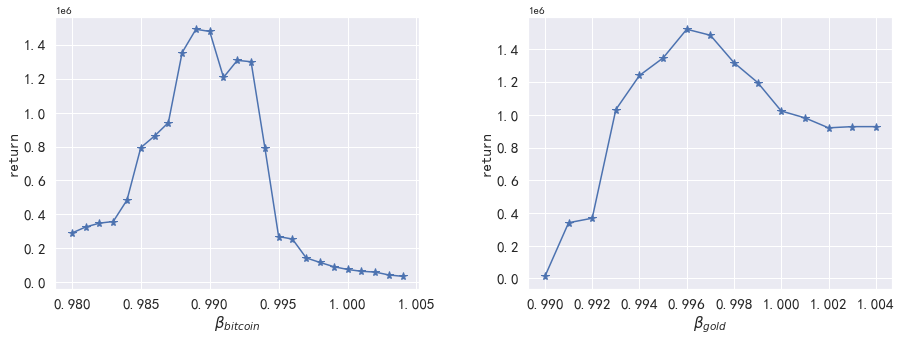

In [247]:

   

    
    
fig = plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.7)

ax1=plt.subplot(1,2,1)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax2=plt.subplot(1,2,2)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

ax1.plot(xzb1, lis1, marker = '*', markersize = 8, # 点的大小
        )
ax1.set_ylabel("return", fontsize = 15)
ax1.set_xlabel(r"$\beta_{bitcoin}$", fontsize = 15)

ax2.plot(xzb2, lis2, marker = '*', markersize = 8, # 点的大小
        )
ax2.set_ylabel("return", fontsize = 15)
ax2.set_xlabel(r"$\beta_{gold}$", fontsize = 15)




plt.savefig("beta.png")
plt.show()

